In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import random
import arviz as az
import pymc as pm
import pymc.sampling.jax as pmjax
import numpy as np

import sys; sys.path.append('../')
from misc import h5file
import yaml

In [2]:
noise_lv = 30
fp1 = "./IPI_output_files/PMS_data.h5"
fp2 = "./IPI_output_files/encoded_pde_names.yaml"
X_pre, best_subsets, un, y_pre = h5file(file_path=fp1, mode='r', return_dict=False)

with open(fp2, 'r') as f:
    config = yaml.load(f, yaml.Loader)
f.close()
encoded_feature_names = config["encoded_feature_names"]
encoded_pde_names = config["encoded_pde_names"]
encoded_pde_names

['X_pre', 'best_subsets', 'un', 'y_pre']


['u*u_1',
 'u_11+u*u_1',
 'u_1+u_11+u*u_1',
 'u_1+u_11+u*u_1+u*u*u_11',
 'u+u*u+u_1+u_11+u*u_1',
 'u+u*u+u_1+u_11+u*u_1+u*u*u_11',
 'u+u*u+u_1+u_11+u*u_1+u*u_11+u*u*u_11',
 'u+u*u+u_1+u_11+u*u_1+u*u*u_1+u*u_11+u*u*u_11']

In [3]:
hie = [np.where(best_subsets[i]>0)[0].tolist() for i in range(best_subsets.shape[-1])][:5]

In [4]:
# Define the Bayesian linear regression model
return_inferencedata = True
init_sigma = 1
init_beta = 1
n_samples = 10000
models = {}
idatas = []
for effective_indices in hie[:3]:
    X_sup = X_pre[:, effective_indices]
    y_sup = y_pre.ravel()
    
    np.random.seed(0)
    with pm.Model() as model:
        coeffs = pm.Normal('coeffs', mu=0, sigma=init_sigma, shape=X_sup.shape[-1])
        sigma = pm.HalfCauchy('sigma', beta=init_beta)
        mu = pm.math.dot(X_sup, coeffs)
        likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_sup)

        # Perform MCMC sampling
        # trace = pm.sample(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=return_inferencedata)
        # trace = pmjax.sample_numpyro_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=return_inferencedata)
        trace = pmjax.sample_blackjax_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=return_inferencedata)
        pm.compute_log_likelihood(trace)
        idata = pm.sample_smc(progressbar=False, cores=4)
        idatas.append(idata)
        
        if return_inferencedata:
            waic = az.waic(trace, pointwise=True); print(waic)
            models[str(len(effective_indices))] = trace

    if not return_inferencedata:
        f_logp = pm.logp(pm.Normal.dist(), y_sup[:, None]-(X@trace['coeffs'].T))
        f_logp = np.mean(f_logp.eval())

        # k is the total number of estimated parameters
        k = len(map_est["coeffs"])
        aic = -2*f_logp+2*k
        bic = -2*f_logp+np.log(X_sup.shape[0])*k
        print("BIC & AIC")
        print(bic, aic)

Compiling...
Compilation time =  0:00:25.985452
Sampling...
Sampling time =  0:00:03.835431
Transforming variables...
Transformation time =  0:00:01.981832


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


    Computed from 40000 posterior samples and 10000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 32610.86   143.97
p_waic        8.79        -
Compiling...
Compilation time =  0:00:04.208505
Sampling...
Sampling time =  0:00:04.830797
Transforming variables...
Transformation time =  0:00:06.548343


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


    Computed from 40000 posterior samples and 10000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 38725.61    72.22
p_waic        3.66        -
Compiling...
Compilation time =  0:00:01.410039
Sampling...
Sampling time =  0:00:06.681365
Transforming variables...
Transformation time =  0:00:18.957248


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


    Computed from 40000 posterior samples and 10000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 38730.21    72.44
p_waic        4.79        -


In [4]:
# Define the Bayesian linear regression model
return_inferencedata = True
init_sigma = 1
init_beta = 1
n_samples = 10000
models = {}
idatas = []
for effective_indices in hie:
    X_sup = X_pre[:, effective_indices]
    y_sup = y_pre.ravel()
    
    np.random.seed(0)
    with pm.Model() as model:
        coeffs = pm.Normal('coeffs', mu=0, sigma=init_sigma, shape=X_sup.shape[-1])
        sigma = pm.HalfCauchy('sigma', beta=init_beta)
        mu = pm.math.dot(X_sup, coeffs)
        likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y_sup)

        # Perform MCMC sampling
        # trace = pm.sample(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=return_inferencedata)
        # trace = pmjax.sample_numpyro_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=return_inferencedata)
        trace = pmjax.sample_blackjax_nuts(n_samples, tune=n_samples//2, chains=4, cores=4, return_inferencedata=return_inferencedata)
        pm.compute_log_likelihood(trace)
        idata = pm.sample_smc(progressbar=False, cores=4)
        idatas.append(idata)
        
        if return_inferencedata:
            waic = az.waic(trace, pointwise=True); print(waic)
            models[str(len(effective_indices))] = trace

    if not return_inferencedata:
        f_logp = pm.logp(pm.Normal.dist(), y_sup[:, None]-(X@trace['coeffs'].T))
        f_logp = np.mean(f_logp.eval())

        # k is the total number of estimated parameters
        k = len(map_est["coeffs"])
        aic = -2*f_logp+2*k
        bic = -2*f_logp+np.log(X_sup.shape[0])*k
        print("BIC & AIC")
        print(bic, aic)

Compiling...
Compilation time =  0:00:01.243102
Sampling...
Sampling time =  0:00:03.818751
Transforming variables...
Transformation time =  0:00:02.027288


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


      Computed from 40000 posterior samples and 10000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 32610.78   144.00
p_waic        8.91        -
Compiling...
Compilation time =  0:00:01.075480
Sampling...
Sampling time =  0:00:03.856517
Transforming variables...
Transformation time =  0:00:05.021556


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


      Computed from 40000 posterior samples and 10000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 38725.62    72.22
p_waic        3.64        -
Compiling...
Compilation time =  0:00:01.023760
Sampling...
Sampling time =  0:00:04.058241
Transforming variables...
Transformation time =  0:00:11.892856


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


      Computed from 40000 posterior samples and 10000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 38730.23    72.45
p_waic        4.76        -
Compiling...
Compilation time =  0:00:01.063430
Sampling...
Sampling time =  0:00:04.251293
Transforming variables...
Transformation time =  0:00:09.229234


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


      Computed from 40000 posterior samples and 10000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 38736.40    72.14
p_waic        6.27        -
Compiling...
Compilation time =  0:00:00.895572
Sampling...
Sampling time =  0:00:03.498545
Transforming variables...
Transformation time =  0:00:14.972116


Initializing SMC sampler...
Sampling 6 chains in 6 jobs


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Computed from 40000 posterior samples and 10000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 38745.95    71.85
p_waic        7.32        -


In [19]:
lmls = []
for idata in idatas:
    lml = np.array(idata.sample_stats["log_marginal_likelihood"].as_numpy(), dtype=np.object_)
    if lml.shape[0] == 1: lml = lml[0]
    # print(lml)
    vals = np.array([l[-1] for l in lml]).mean()
    lmls.append(vals)

print(lmls)
print([np.exp(lmls[i]-lmls[i-1]) for i in range(1, len(lmls))])
print([np.exp(lmls[i]-lmls[i-1])>1 for i in range(1, len(lmls))])
print(np.argmax(lmls)+1) # 3

[32601.275328171516, 38704.655098445146, 38702.729779769295, 38702.109736275794, 38692.24483001932]
[inf, 0.14582927718170102, 0.5379210410161529, 5.196676093926926e-05]
[True, False, False, False]
2


/var/folders/z3/_stfms3523dd5mnfr3ch5n100000gp/T/ipykernel_12254/3879611979.py:10: RuntimeWarning: overflow encountered in exp
  print([np.exp(lmls[i]-lmls[i-1]) for i in range(1, len(lmls))])
/var/folders/z3/_stfms3523dd5mnfr3ch5n100000gp/T/ipykernel_12254/3879611979.py:11: RuntimeWarning: overflow encountered in exp
  print([np.exp(lmls[i]-lmls[i-1])>1 for i in range(1, len(lmls))])


In [20]:
loo_df = az.compare(models)

In [21]:
waic_df = az.compare(models, ic='waic', scale='negative_log')

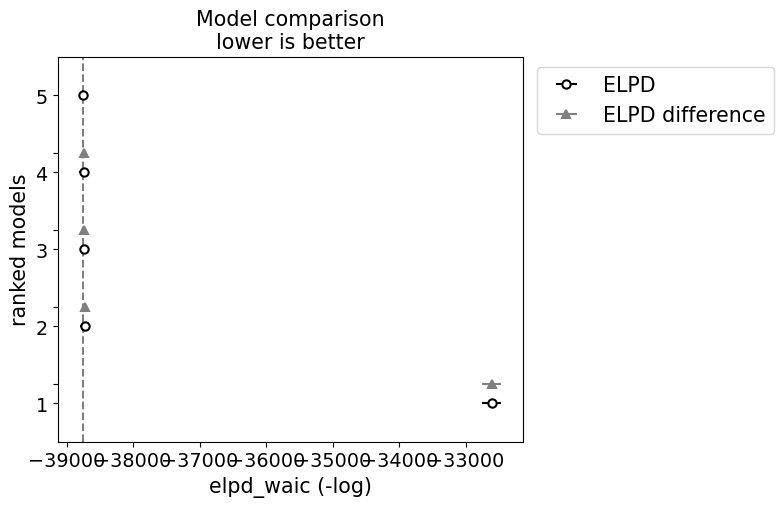

In [22]:
az.plot_compare(waic_df)
plt.show()

In [23]:
from scipy import stats

aaa = pm.waic(models['2'], pointwise=True)
bbb = pm.waic(models['3'], pointwise=True)

dist1 = np.array(aaa.waic_i)
dist2 = np.array(bbb.waic_i)

# Perform one-sided two-sample t-test
t_statistic, p_value = stats.ttest_ind(dist2, dist1, alternative='less')
print("t_statistic, p_value =", t_statistic, p_value)

# Define significance level
alpha = 0.05

# Check if the null hypothesis can be rejected
if p_value < alpha:
    print("Reject the null hypothesis. Distribution 2 is significantly less than distribution 1.")
else:
    print("Fail to reject the null hypothesis. Distribution 2 is not significantly less than distribution 1.")

t_statistic, p_value = 0.04507640884172801 0.5179765723040032
Fail to reject the null hypothesis. Distribution 2 is not significantly less than distribution 1.
